## Heart Disease Analysis

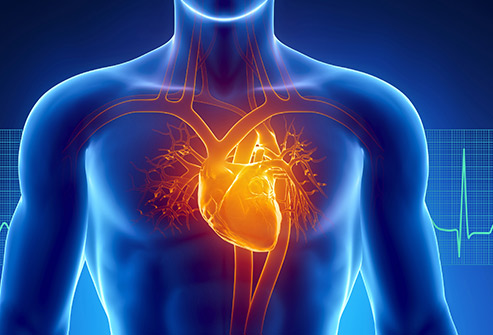

## Table of Contents

1. [Introduction](#intro)
2. [Overview](#overview)
3. [Import Data](#import)
4. [Exploratory Data Analysis](#eda)
5. [Correlation Matrix](#corr)
6. [Preprocessing](#preprocessing)
7. [Model Building](#model)
8. [Visualizations](#vis)
9. [Odds Ratios](#odds)
10. [Conclusion](#conclusion)
11. [References](#ref)

## 1. Introduction <a id = 'intro'></a>

Heart disease is consistently the leading cause of death in the United States year after year. According to Centers for Diseases Control and Prevention (CDC), about 647,000 Americans die from heart disease each year — that’s 1 in every 4 deaths. In this notebook, we'll model the dataset using logistic regression and visualize the results.

## 2. Overview <a id = 'overview'></a>


Lets go over the variables in the data set.

age: how old a person is in years

sex: gender (1 = male, 0 = female)

cp: chest pain type. This category is vague, there's no description of each type. Lets assume the following:  
    (0 = no chest pain, 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain)
    Note, angina is chest pain when there is reduced blood flow to the heart.

trestbps: resting blood pressure on admission to hospital (measured in mm Hg)

chol: total serum cholesterol calculated by adding the HDL, LDL, and 20 percent of the triglyceride 
    levels. (measured in mg/dl)

fbs: fasting blood sugar > 120 mg/dl (1 = true, 0 = false)

restecg: resting electrocardiographic results 
    (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular 
    hypertrophy by Estes' criteria)

thalach: max heart rate achieved (bps)

exang: exercise induced angina (0 = no, 1 = yes)

oldpeak: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more here)

slope: the slope of the ST segment in an ecg during exercise. This attribute is vague, there's no 
    description of each value, Lets assume the following:
    (0 = positive slope, 1 = flat, 2 = negative slope)

ca: number of major vessels colored during a fluoroscopy (0-3)

thal: thallium scintigraphy is an alternate non-invasive method to test for heart disease
    (1 = normal; 2 = fixed defect; 3 = reversable defect)

target: Is heart disease present? (0 = no, 1 = yes)

## 3. Import Data<a id = 'import'></a>

Lets import the dataset, make some adjustments interpretation and take a look at what we have.

In [550]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math 
from scipy import stats as ss


In [551]:
df = pd.read_csv('C:/Users/dhuan/Desktop/Datasets/heart.csv')
pd.options.display.max_columns = None
pd.options.display.max_rows = None
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Lets change the variable names to be a bit clearer and easier to interpret later on.

trestbps to rest_bp, thalach to max_bps, exang to ex_angina, oldpeak to st_depression, slope to ecg_st_slope, ca to cardiac_fluoro, thal to thallium

In [552]:
columns_names = ['age', 'sex_male', 'cp', 'rest_bp', 'chol', 'fbs_above_120', 'rest_ecg',
       'max_bps', 'ex_angina', 'st_depression', 'ecg_st_slope', 'cardiac_fluoro', 'thallium', 'target']
df.columns = columns_names

Let's also change the order to the following:

demographics - age, sex

basic info - rest_bp, chol, fbs, max_bps, cp, ex_angina

ecg related - restecg, oldpeak, ecg_st_slope

alt ecg method - thallium, cardiac_fluoro

target

In [553]:
columns_names_reordered = ['age', 'sex_male', 'rest_bp', 'chol', 'fbs_above_120',
       'max_bps', 'cp', 'ex_angina', 'rest_ecg', 'st_depression', 'ecg_st_slope', 'thallium', 'cardiac_fluoro', 'target']
df = df[columns_names_reordered]

## 4. Exploratory Data Analysis<a id = 'eda'></a>

Let’s do an exploratory analysis of the dataset to get a general sense of what we are working with and how each attribute relates to the presence of heart disease. First let’s check if our target class is skewed or not. We don't want our model accuracy being 95% and to find out that our target variable was 95% true for heart disease!

Text(0.5, 1.0, 'Heart Disease Count')

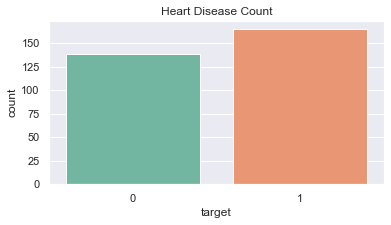

In [554]:
#plot settings
sns.set(style = 'darkgrid')
plt.figure(figsize = (6,3))

#countplot
sns.countplot(x = "target", data = df, palette="Set2")
plt.title('Heart Disease Count')

Okay. Looks okay, not too skewed. If a dataset is highly imbalanced, we might not have enough information for the machine learning model. There is an interesting method called upscaling used for imbalanced datasets. One such method is SMOTE, take a look at the link if you want to know more.

https://medium.com/@saeedAR/smote-and-near-miss-in-python-machine-learning-in-imbalanced-datasets-b7976d9a7a79

Lets move on to our categorical variables: sex, cp, fbs,  restecg, exang, ca, thal.

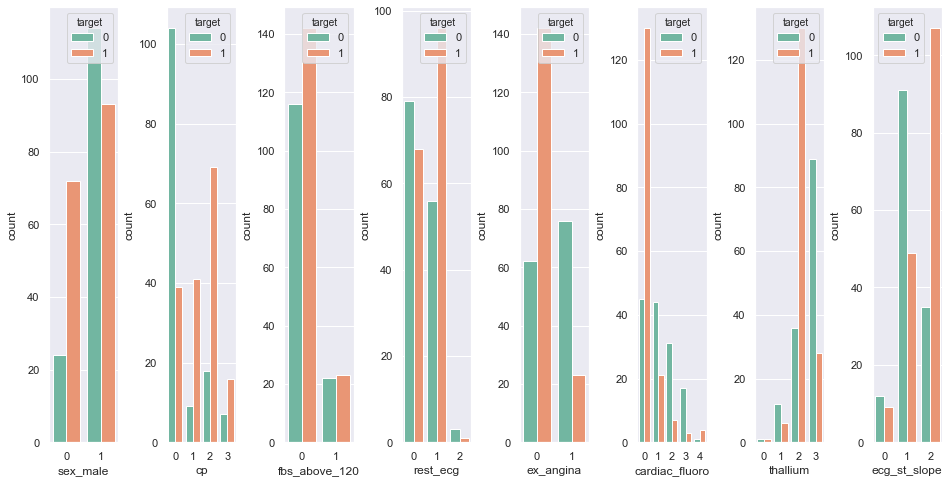

In [555]:
#plot settings
sns.set(style = 'darkgrid')
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(1,8,figsize=(16,8))
fig.subplots_adjust(hspace=0.4, wspace=0.7)

#countplots
sns.countplot(x = 'sex_male', hue ='target', data = df, ax = ax1, palette = 'Set2')
sns.countplot(x = 'cp', hue = 'target', data = df, ax = ax2, palette = 'Set2')
sns.countplot(x = 'fbs_above_120', hue = 'target', data = df, ax = ax3, palette = 'Set2')
sns.countplot(x = 'rest_ecg', hue = 'target', data = df, ax = ax4, palette = 'Set2')
sns.countplot(x = "ex_angina", hue = 'target', data = df, ax = ax5, palette = 'Set2')
sns.countplot(x = "cardiac_fluoro", hue = 'target', data = df, ax = ax6, palette = 'Set2')
sns.countplot(x = "thallium", hue = 'target', data = df, ax = ax7, palette = 'Set2')
sns.countplot(x = "ecg_st_slope", hue = 'target', data = df, ax = ax8, palette = 'Set2')

From the simple bar charts, we can tell there is a clear distinction between those that do and do not have heart disease when looking at the variables sex, cp and ca. 

Okay, lets take a look at our numerical variables using boxplots.

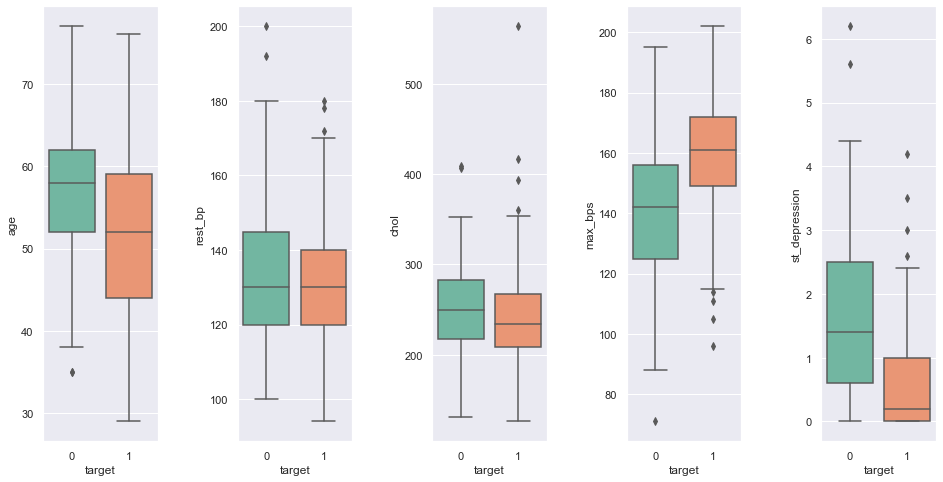

In [347]:
#plot settings
sns.set(style = 'darkgrid')
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(16,8))
fig.subplots_adjust(hspace=0.4, wspace=0.7)

#boxplots
sns.boxplot(x = 'target', y ='age', data = df, ax = ax1, palette = 'Set2')
sns.boxplot(x = 'target', y ='rest_bp', data = df, ax = ax2, palette = 'Set2')
sns.boxplot(x = 'target', y ='chol', data = df, ax = ax3, palette = 'Set2')
sns.boxplot(x = 'target', y ='max_bps', data = df, ax = ax4, palette = 'Set2')
sns.boxplot(x = 'target', y ='st_depression', data = df, ax = ax5, palette = 'Set2')

There seems to be the most distinction of those that do and do not have heart disease when looking at thalach and oldpeak.

Let’s visualize all our numerical data in pair-wise grid plot to get a different view. Hopefully we can see some clustering.


<Figure size 1008x864 with 0 Axes>

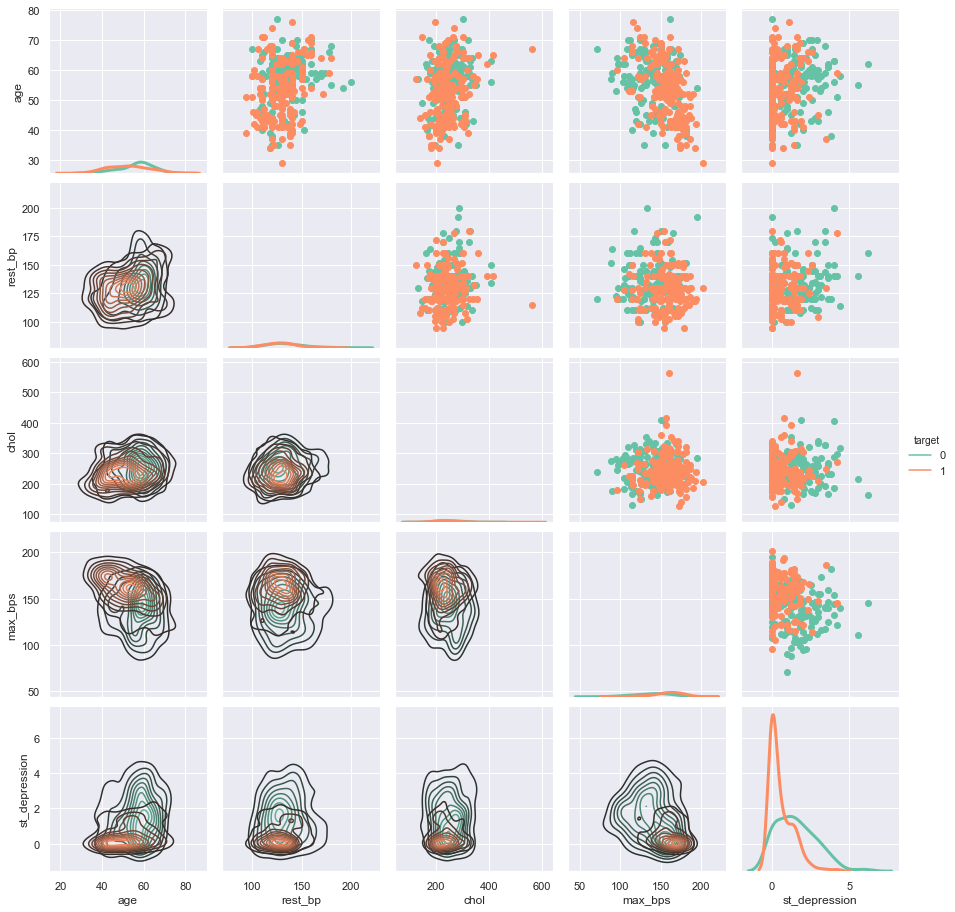

In [349]:
#plot settings
plt.figure(figsize = (14,12))

#plot pairwise graphs
ax = sns.PairGrid(df, vars=['age', 'rest_bp','chol', 'max_bps', 'st_depression'], hue="target", palette = 'Set2')
ax.map_upper(plt.scatter)
ax.map_lower(sns.kdeplot)
ax.map_diag(sns.kdeplot, lw=3, legend=False)
ax.add_legend()

Interesting... there is a notice difference between people with and without heart disease across the numerical variable pair plots. We can see that the bivariate concentrations clearly in the density plots, with the most distinction in st_depression (oldpeak).

## 5. Correlation Matrix<a id = 'corr'></a>

Variables that are highly correlated with each other, that is if one increases the other increases at the same rate, can produce noise and redundancy in our model. Let’s look to see if there are any and removed them if present. We can also see what factors correlates to having heart disease.

Correlation between numerical and categorical variables can be tricky and there isn't as much information on it as numerical to numerical and categorical to categorical correlation. We'll use Pearson's for the numerical variables and Cramer's V for the categorical variables. Cramer's can handle ranked and non-ranked categorical variables.


In [556]:
#specify the numerical variables
df_num = df[['age', 'rest_bp', 'chol', 'max_bps', 'st_depression', 'cardiac_fluoro']]

[Text(0, 0.5, 'age'),
 Text(0, 1.5, 'rest_bp'),
 Text(0, 2.5, 'chol'),
 Text(0, 3.5, 'max_bps'),
 Text(0, 4.5, 'st_depression'),
 Text(0, 5.5, 'cardiac_fluoro')]

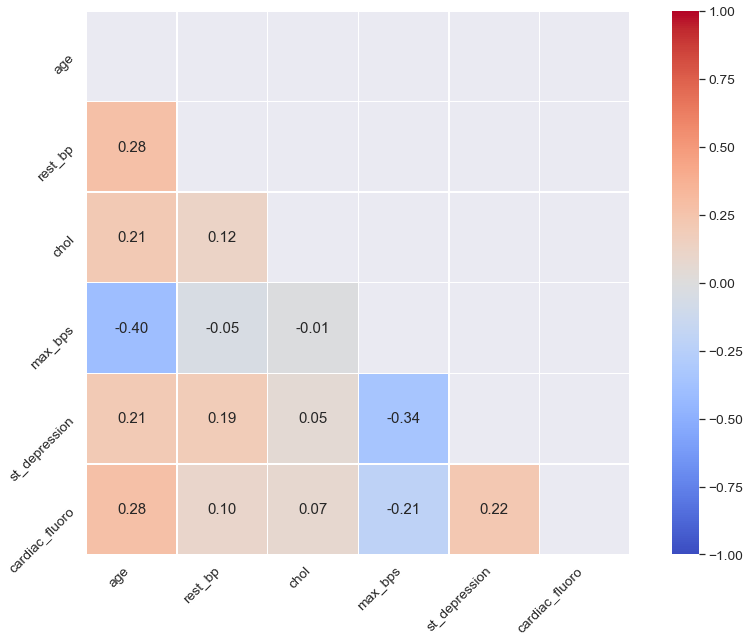

In [557]:
#add a mask to hide identical pairwise correlations
mask = np.zeros_like(df_num.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#plot settings
sns.set(font_scale=1.25)
plt.figure(figsize = (15,10))

#correlation matrix
corrMatrix = df_num.corr()
g = sns.heatmap(corrMatrix, vmin = -1,cmap='coolwarm', fmt='.2f', annot = True,
                square = True, linewidths = .5,mask = mask)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right')


In [558]:
#specify the categorical variables
df_cramer = df[['cp', 'sex_male', 'fbs_above_120', 'ex_angina', 'rest_ecg', 'ecg_st_slope', 'thallium', 'target']]

In [559]:
#Cramer's V correlation matrix, used for categorical variables
#https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

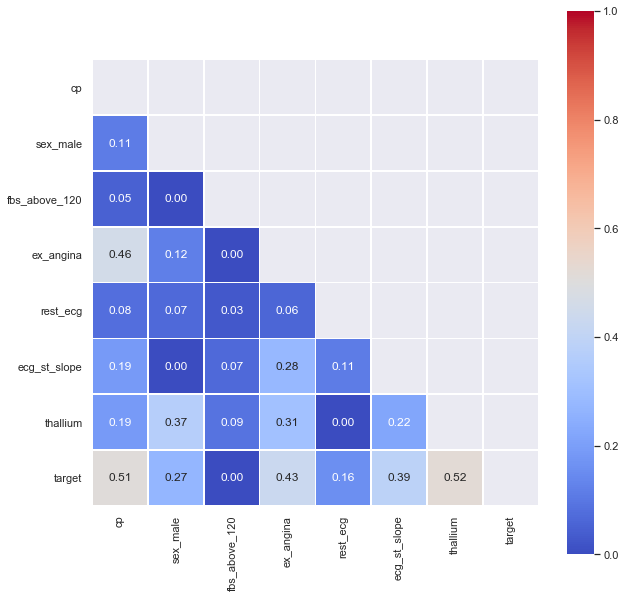

In [560]:
#create the cramers correlation matrix
rows= []

for var1 in df_cramer:
    col = []
    for var2 in df_cramer:
        cramers =cramers_v(df_cramer[var1], df_cramer[var2])
        col.append(round(cramers,2)) 
    rows.append(col)

cramers_results = np.array(rows)
df_cramer_corr = pd.DataFrame(cramers_results, columns = df_cramer.columns, index =df_cramer.columns)

#mask the diagonial and top triangle
mask = np.zeros_like(df_cramer_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#set correlation graph size
sns.set(font_scale=1)
plt.figure(figsize = (10,10))

#correlation graph settings
ax = sns.heatmap(df_cramer_corr, vmin=0., vmax=1,cmap='coolwarm', fmt='.2f', annot = True, square = True,
                 linewidths = .5,mask = mask)
plt.show()

Nothing alarming, it looks like there are no highly correlated variables (>.8). 

## 6. Preprocessing<a id = 'preprocessing'></a>

Lets check for missing values in the dataset, all the value counts for each column should be 303.

In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             303 non-null    int64  
 1   sex_male        303 non-null    int64  
 2   rest_bp         303 non-null    int64  
 3   chol            303 non-null    int64  
 4   fbs_above_120   303 non-null    int64  
 5   max_bps         303 non-null    int64  
 6   cp              303 non-null    int64  
 7   ex_angina       303 non-null    int64  
 8   rest_ecg        303 non-null    int64  
 9   st_depression   303 non-null    float64
 10  ecg_st_slope    303 non-null    int64  
 11  thallium        303 non-null    int64  
 12  cardiac_fluoro  303 non-null    int64  
 13  target          303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Dummy variables for categorical variables work better with machine learning models. Lets transform the categorical variables to dummy variables.

In [561]:
#Create dummy variables for the following categorical attributes
#cp, rest_ecg, ecg_st_slope, cardiac_fluoro, thallium
cp_dummy = pd.get_dummies(df['cp'], drop_first = True)
cp_dummy.columns = ['cp_typical', 'cp_atypical', 'cp_non_anginal']

rest_ecg_dummy = pd.get_dummies(df['rest_ecg'], drop_first = True)
rest_ecg_dummy.columns = ['rest_ecg_st_abnormal', 'rest_ecg_left_vent_hyper']

ecg_st_slope_dummy = pd.get_dummies(df['ecg_st_slope'], drop_first = True)
ecg_st_slope_dummy.columns = ['ecg_st_slope_1', 'ecg_st_slope_2']

thallium_dummy = pd.get_dummies(df['thallium'], drop_first = True)
thallium_dummy.columns = ['thallium_normal', 'thallium_abnormal', 'thallium_rev_defect']


In [562]:
#add the dummy variables to our df
df = pd.concat([df, cp_dummy, rest_ecg_dummy, ecg_st_slope_dummy, thallium_dummy], axis =1)

In [563]:
#remove the original attributes of the dummy variables
df = df.drop(columns = ['cp', 'rest_ecg', 'ecg_st_slope', 'thallium'])

In [564]:
df.head(10)

,age,sex_male,rest_bp,chol,fbs_above_120,max_bps,ex_angina,st_depression,cardiac_fluoro,target,cp_typical,cp_atypical,cp_non_anginal,rest_ecg_st_abnormal,rest_ecg_left_vent_hyper,ecg_st_slope_1,ecg_st_slope_2,thallium_normal,thallium_abnormal,thallium_rev_defect
0,63,1,145,233,1,150,0,2.3,0,1,0,0,1,0,0,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,1,0,1,0,1,0,0,0,0,1,0
2,41,0,130,204,0,172,0,1.4,0,1,1,0,0,0,0,0,1,0,1,0
3,56,1,120,236,0,178,0,0.8,0,1,1,0,0,1,0,0,1,0,1,0
4,57,0,120,354,0,163,1,0.6,0,1,0,0,0,1,0,0,1,0,1,0
5,57,1,140,192,0,148,0,0.4,0,1,0,0,0,1,0,1,0,1,0,0
6,56,0,140,294,0,153,0,1.3,0,1,1,0,0,0,0,1,0,0,1,0
7,44,1,120,263,0,173,0,0.0,0,1,1,0,0,1,0,0,1,0,0,1
8,52,1,172,199,1,162,0,0.5,0,1,0,1,0,1,0,0,1,0,0,1
9,57,1,150,168,0,174,0,1.6,0,1,0,1,0,1,0,0,1,0,1,0


Looking at the target column, all the values are '1' are on the top of the dataset, we'll need to randomize it the dataset. 

In [565]:
#randomize the sample set
df = df.sample(frac=1).reset_index(drop=True)

## Checkpoint

We'll be setting a copy of our preprocessed dataset. It is always good to have a checkpoint just in case you inadvertently changed it during the model building process. All you need to do is to come back here and reset it.

In [566]:
df1 = df.copy()

## 7. Model Building <a id = 'model'></a>

We'll concentrate on logistic regression for this process. Logistic regression is a traditional well-known supervised machine learning model that provides an extremely high level of interpretability, as opposed to black box models. Also, odds ratios are widely used in medical research and logistic regression is based on it.

Logistic regression is a linear optimization problem, when solved produces a sample equation below. The betas are the slopes, the x's are the unit values of the variables, and p is the probability. A sample univariate graph looking at the probability of passing an exam vs hours of studying from Wiki is displayed below. 


See the Wiki page for more information.
https://en.wikipedia.org/wiki/Logistic_regression

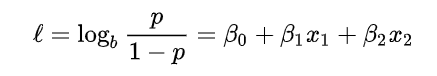

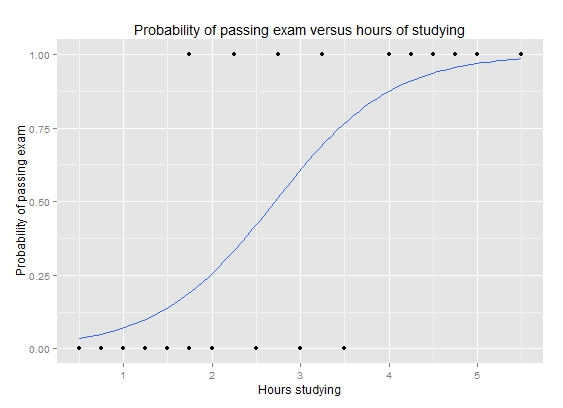

First, we'll have to assess which variables impact the presence of the heart disease the most. We don't want insignificant variables introducing noise into our final model. There are numerous ways to do this; iterations, correlation graphs, and even a brute force approach (try every single combination of variables).

In [567]:
#specify independent and dependent variables
y = df1['target']
X = df1[['age', 'sex_male', 'rest_bp', 'chol', 'fbs_above_120', 'max_bps', 'ex_angina', 'st_depression',
         'cardiac_fluoro', 'cp_typical', 'cp_atypical', 'cp_non_anginal', 'rest_ecg_st_abnormal',
         'rest_ecg_left_vent_hyper', 'ecg_st_slope_1', 'ecg_st_slope_2', 'thallium_abnormal', 
         'thallium_rev_defect']]


Remember in the beginning when we looked at our dataset and saw that it was slightly imbalanced? We can fix that using SMOTE, a machine learning algorithm that generates extra synthetic rows of the balanced target variable. In this case, it was a coin toss on the level of performance improvement but I’ll leave the code here.

In [568]:
#from imblearn.over_sampling import SMOTE

#smt = SMOTE()
#X, y = smt.fit_sample(X, y)

Run the initial model with all the variables. We'll be using cross validation to measure our performance. I prefer this method of validation because the whole data set will have a chance to be used as either the training and testing set. The plus or minus values (variation) will be across the folds. 

In [569]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#model
model = LogisticRegression(max_iter=3000)

#performance metrics
accuracy = cross_val_score(model, X, y, cv=4)
avg_accuracy = np.mean(accuracy)
print('Accuracy:', round((avg_accuracy)*100,2), '%', '+/-', round((max(accuracy)-avg_accuracy)*100,2), '%')

recall = cross_val_score(model, X, y, scoring = 'recall', cv= 4)
avg_recall = np.mean(recall)
print('Recall:', round((avg_recall)*100,2), '%', '+/-', round((max(recall)-avg_recall)*100,2), '%')

precision = cross_val_score(model, X, y, scoring = 'precision', cv= 4)
avg_precsion = np.mean(precision)
print('Precision:', round((avg_precsion)*100,2), '%', '+/-', round((max(precision)-avg_precsion)*100,2), '%')



Accuracy: 83.16 % +/- 3.68 %
Recall: 87.34 % +/- 7.78 %
Precision: 83.12 % +/- 5.77 %


Now, we can start removing variables that do not provide much information to our model or are not statistically significant. We'll be going over two methods, the first method is to look at the p-values. The logistic regression provides p-values, from that we can determine the significance of each variable. Less than .05 is statistically significant.

In [570]:
import statsmodels.api as sm

#run logistic regression
logit_model = sm.Logit(y,X)
result=logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.335494
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                  303
Model:                          Logit   Df Residuals:                      285
Method:                           MLE   Df Model:                           17
Date:                Sat, 23 May 2020   Pseudo R-squ.:                  0.5132
Time:                        12:10:14   Log-Likelihood:                -101.65
converged:                       True   LL-Null:                       -208.82
Covariance Type:            nonrobust   LLR p-value:                 3.703e-36
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
age                          0.0123      0.020      0.613      0.540      -0.027       0.051
sex_male                    -1.3319      0.494     -2.697      0.007      -2.300      -0.364
rest_bp                     -0.0134      0.010     -1.331      0.183      -0.033       0.006
chol                        -0.0035      0.004     -0.909      0.363      -0.011       0.004
fbs_above_120                0.0802      0.555      0.144      0.885      -1.008       1.168
max_bps                      0.0229      0.009      2.576      0.010       0.005       0.040
ex_angina                   -0.7179      0.420     -1.710      0.087      -1.541       0.105
st_depression               -0.4499      0.222     -2.028      0.043      -0.885      -0.015
cardiac_fluoro              -0.8219      0.203     -4.057      0.000      -1.219      -0.425
cp_typical                   0.9812      0.559      1.756      0.079      -0.114       2.077
cp_atypical                  1.9191      0.474      4.047      0.000       0.990       2.848
cp_non_anginal               1.9236      0.639      3.011      0.003       0.672       3.176
rest_ecg_st_abnormal         0.6332      0.367      1.723      0.085      -0.087       1.353
rest_ecg_left_vent_hyper    -0.2058      2.281     -0.090      0.928      -4.676       4.264
ecg_st_slope_1              -0.5081      0.806     -0.630      0.528      -2.088       1.072
ecg_st_slope_2               0.3515      0.896      0.392      0.695      -1.405       2.108
thallium_abnormal            0.3437      0.735      0.468      0.640      -1.096       1.784
thallium_rev_defect         -1.1017      0.732     -1.506      0.132      -2.535       0.332
============================================================================================
"""

It looks like the p-values are too high for the following variables: age, fbs_above_120, rect_ecg_left_vent_hyper, ecg_st_slope_1, ecg_st_slope_2, thallium_abnormal.

We can remove them from use as they do not provide much useful information for our model. 

Another method is Recursive Feature Elimination where the model is initially run with all the variables. Then an importance coefficient is obtained for each variable. Then the least important features are removed from the model. We can specify how many features we want to keep.


In [571]:
from sklearn.feature_selection import RFE

# the model
model = LogisticRegression(max_iter=3000)

#run RFE
rfe = RFE(model, 10)
rfe = rfe.fit(X, y)

#display the ranking of each variable
series1 = pd.Series(X.columns.values)
series2 = pd.Series(rfe.ranking_)

rank = pd.DataFrame(data={'Variables': series1, 'Ranking' : series2})
rank.sort_values(by='Ranking')


,Variables,Ranking
8,cardiac_fluoro,1
14,ecg_st_slope_1,1
12,rest_ecg_st_abnormal,1
11,cp_non_anginal,1
10,cp_atypical,1
9,cp_typical,1
16,thallium_abnormal,1
17,thallium_rev_defect,1
6,ex_angina,1
1,sex_male,1


The variables kept for the final model is shown below. I used a combination of both methods.

In [572]:
X_adj = X[['sex_male', 'max_bps', 'ex_angina', 'st_depression',
         'cardiac_fluoro', 'cp_typical', 'cp_atypical', 'cp_non_anginal', 'rest_ecg_st_abnormal', 
         'thallium_rev_defect']]

Now we'll rerun the model and see what the difference is.

In [573]:
#model
model = LogisticRegression(max_iter=3000)

#performance metrics
accuracy = cross_val_score(model, X_adj, y, cv=4)
avg_accuracy = np.mean(accuracy)
print('Accuracy:', round((avg_accuracy)*100,2), '%', '+/-', round((max(accuracy)-avg_accuracy)*100,2), '%')

recall = cross_val_score(model, X_adj, y, scoring = 'recall', cv= 4)
avg_recall = np.mean(recall)
print('Recall:', round((avg_recall)*100,2), '%', '+/-', round((max(recall)-avg_recall)*100,2), '%')

precision = cross_val_score(model, X_adj, y, scoring = 'precision', cv= 4)
avg_precsion = np.mean(precision)
print('Precision:', round((avg_precsion)*100,2), '%', '+/-', round((max(precision)-avg_precsion)*100,2), '%')

Accuracy: 83.83 % +/- 1.69 %
Recall: 89.14 % +/- 5.98 %
Precision: 82.67 % +/- 2.33 %


Not too much improvement in the average values but the variation is a lot tighter. I'm happy with that.

Let’s look at the ROC curve to see the prediction power of our model. The more the curve is skewed towards the upper left hand corner, the better. The closer it is to the diagonal, the more random the model is.


AUC: 92.54 %


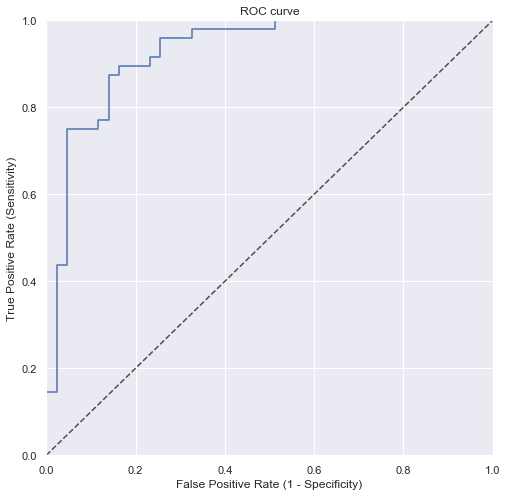

In [574]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

#split the data
X_train, X_test, y_train, y_test = train_test_split(X_adj, y, test_size=0.3, random_state=0)

#the model
model = LogisticRegression(max_iter=3000)
      
#fit and predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]

#ROC graph x and y axis
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)
print('AUC:', round((auc(fpr, tpr))*100,2), '%')

#plot the ROC graph
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

The logistic model seems to have a high prediction power and can be deemed an appropriate fit.

Okay for healthcare data, an extremely important performance metric is specificity. That is the true negative rate. The higher it is, the less false negatives we will have. A false negative is when a patient has a condition, but the prediction was false, leaving the patient going untreated, a Type II error. 

Cross validate from the sklearn library does not provide a specificity scoring method. We'll create it ourselves and also try a different custom performance method for this one. The data will be randomized, split into a 70/30 and the performance values will be calculated. We'll repeat this for x amount of times. Then we can get an average value and compute a 95% confident interval. I expect the variation to be higher since we are running it a large amount of times and the model to follow normality (bell curve). It's interesting to play around with how many times we run the model and see the variation in performance values and the ROC curves.


Accuracy: 83.52 % +/- 5.94 %
Specificity: 78.49 % +/- 13.33 %
Recall: 87.7 % +/- 9.86 %
Precision: 83.41 % +/- 8.62 %
F Measure: 85.32 % +/- 4.97 %
AUC: 90.77 % +/- 5.93 %


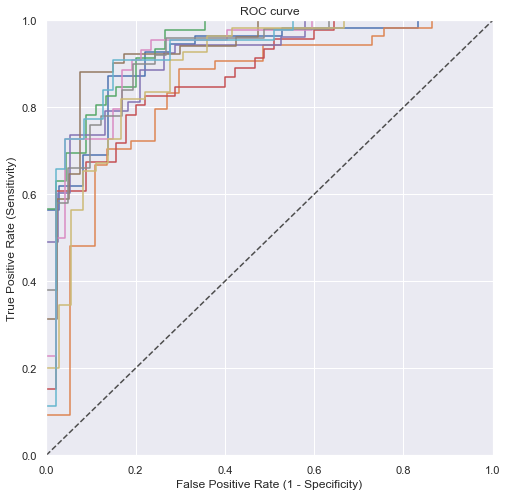

In [575]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from statistics import mean 
from scipy import stats as ss

#store the performance values for aggregation of our loop
specificity_store = []
recall_store = []
precision_store = []
f_measure_store = []
accuracy_store = []
auc_store = []

#ROC plot settings
fig, ax = plt.subplots(figsize = (8,8))
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])    
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
    

#specificy how many times to run the model
x = 10

#run the model x times
for i in range(x):
    #randomize the dataset and specify X and y
    df1_rand = df1.sample(frac=1).reset_index(drop=True)
    y = df1_rand['target']
    X_adj = df1_rand[['sex_male', 'max_bps', 'ex_angina', 'st_depression',
                      'cardiac_fluoro', 'cp_typical', 'cp_atypical', 'cp_non_anginal', 'rest_ecg_st_abnormal',
                      'thallium_rev_defect']]
    #split the data
    X_train, X_test, y_train, y_test = train_test_split(X_adj, y, test_size=0.3, random_state=0)
    
    #run the model
    model = LogisticRegression(max_iter=3000) 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #ROC plot
    y_pred_quant = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)
    ax.plot(fpr, tpr)
    
    #calculate and store performance metrics
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
    
    specificity = TN / (TN + FP)
    specificity_store.append(specificity)

    recall = TP/ (TP + FN)
    recall_store.append(recall)
    
    precision = TP / (TP + FP)
    precision_store.append(precision)
    
    f_measure = (2 * TP) / ((2 * TP) + FP + FN)
    f_measure_store.append(f_measure)

    accuracy = (TP + TN)/ (TN + FP + FN + TP)
    accuracy_store.append(accuracy)

    auc_store.append(auc(fpr, tpr))

#performance metrics
avg_accuracy = np.mean(accuracy_store)
print('Accuracy:', round((avg_accuracy)*100,2), '%', '+/-', round(np.std(accuracy_store) * 1.96 * 100,2), '%')

avg_specificity = np.mean(specificity_store)
print('Specificity:', round((avg_specificity)*100,2), '%', '+/-', round(np.std(specificity_store) * 1.96 * 100,2), '%')

avg_recall = np.mean(recall_store)
print('Recall:', round((avg_recall)*100,2), '%', '+/-', round(np.std(recall_store) * 1.96 * 100,2), '%')

avg_precision = np.mean(precision_store)
print('Precision:', round((avg_precision)*100,2), '%', '+/-', round(np.std(precision_store) * 1.96 * 100,2), '%')

avg_f_measure = np.mean(f_measure_store)
print('F Measure:', round((avg_f_measure)*100,2), '%', '+/-', round(np.std(f_measure_store) * 1.96 * 100,2), '%')

avg_auc = np.mean(auc_store)
print('AUC:', round((avg_auc)*100,2), '%', '+/-', round(np.std(auc_store) * 1.96 * 100,2), '%')



It is interesting to see how the performance metrics are different. The variation is higher than in the cross validate method but specificity should be around 79%. So our model is better at tell us who has heart disease (recall) than as oppose to not having heart disease (specificity).

## 8. Visualizations<a id = 'vis'></a>

On to the more aesthetically pleasing part of the analysis. Visualizations provide us a way of conveying the model to the audience. We'll select some top variables and see the probability of heart disease changes as the variable increases or decreases. We'll be using the pdpbox library, I don't think it is a standard library so you may need to install it.

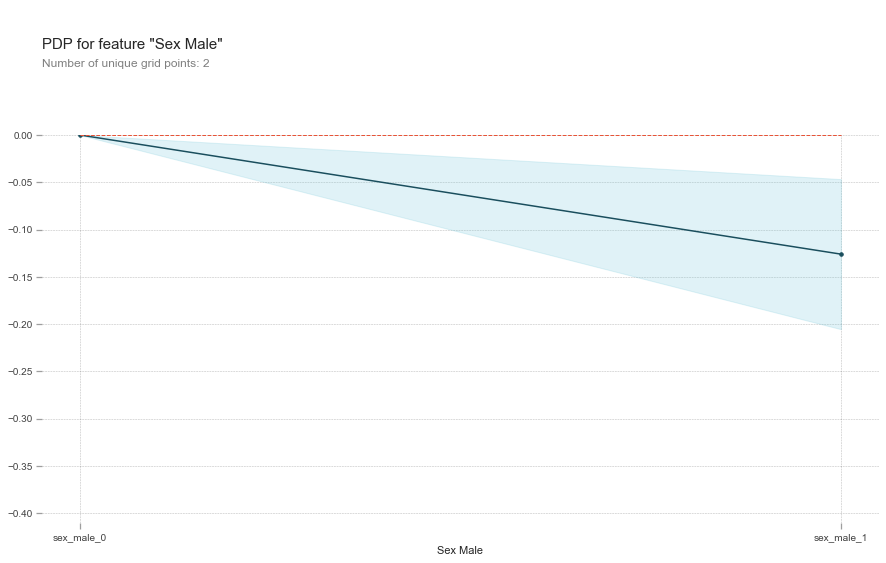

In [522]:
from pdpbox import pdp, get_dataset, info_plots

#specify the variables to grab from
var_names = pd.Series(X_adj.columns.values)

# Create the data that we will plot
pdp_sex_male = pdp.pdp_isolate(model=model, dataset = df1, model_features=var_names, feature = 'sex_male')

# plot it
pdp.pdp_plot(pdp_sex_male, 'Sex Male')
plt.show()

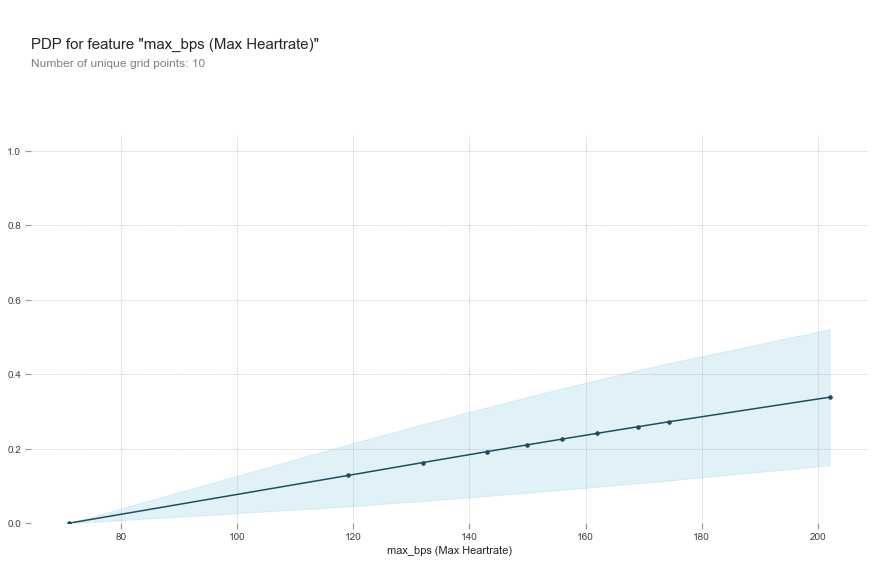

In [523]:
# Create the data that we will plot
pdp_max_bps = pdp.pdp_isolate(model=model, dataset = df1, model_features=var_names, feature='max_bps')

# plot it
pdp.pdp_plot(pdp_max_bps, 'max_bps (Max Heartrate)')
plt.show()

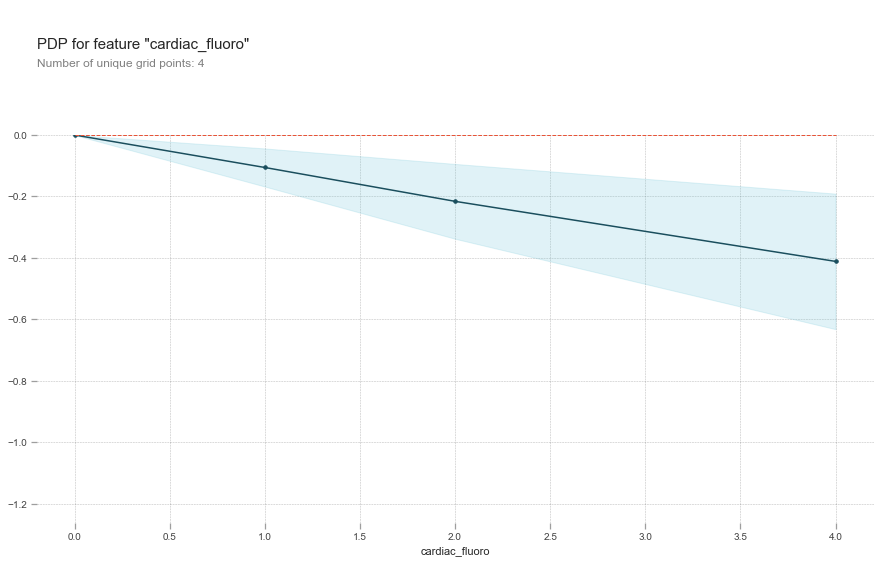

In [524]:
# Create the data that we will plot
pdp_cardiac_fluoro = pdp.pdp_isolate(model = model, dataset = df1,
                                     model_features = var_names, feature = 'cardiac_fluoro')

# plot it
pdp.pdp_plot(pdp_cardiac_fluoro, 'cardiac_fluoro')
plt.show()

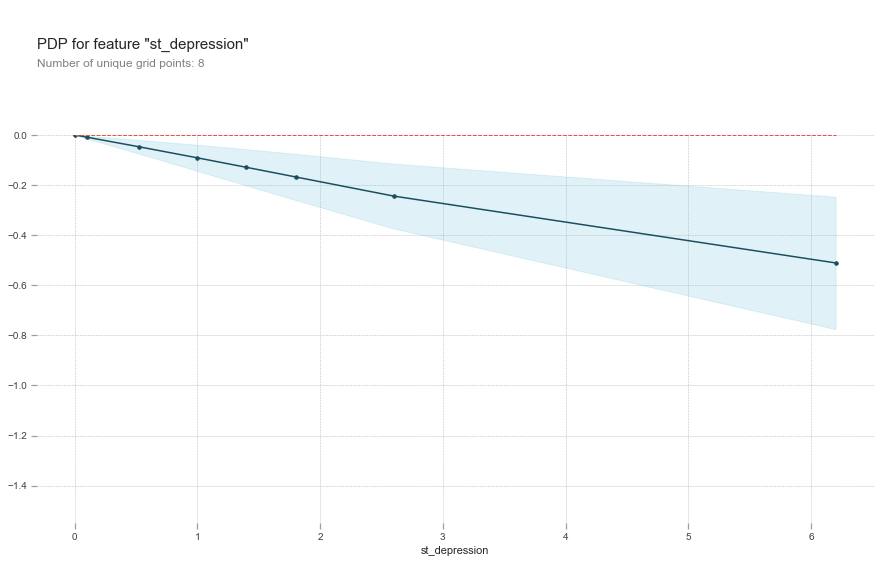

In [525]:
# Create the data that we will plot
pdp_st_depression = pdp.pdp_isolate(model = model, dataset = df1,
                                     model_features = var_names, feature = 'st_depression')

# plot it
pdp.pdp_plot(pdp_st_depression, 'st_depression')
plt.show()

St_depression (oldpeak) provides the most change in probability. We also saw this variable showing the most separation in the pairwise plots in the exploratory data analysis. 


We can also see how the change of two variables affect the probability. Yellow is the highest probability of heart disease. The darker, it is the less chance of heart disease.

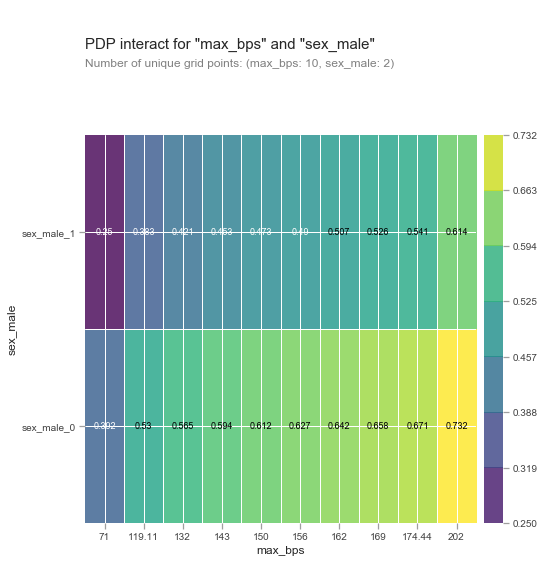

In [526]:

features_to_plot = ['max_bps', 'sex_male']
inter1  =  pdp.pdp_interact(model=model, dataset=df1, model_features=var_names,
                            features=features_to_plot,num_grid_points=[10, 10])

fig, axes = pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot,
                                  plot_type='grid')

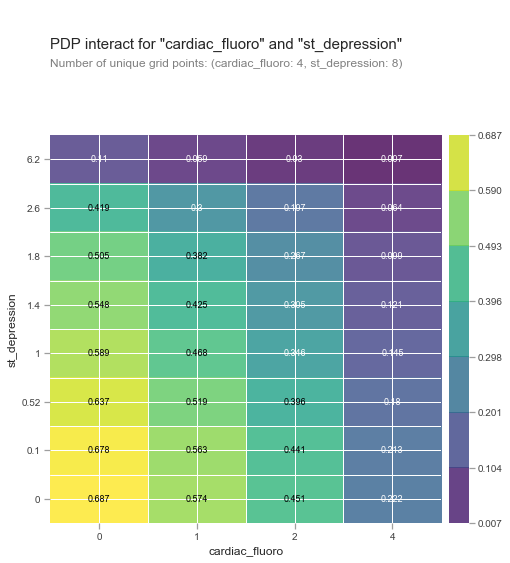

In [527]:

features_to_plot = ['cardiac_fluoro', 'st_depression']
inter1  =  pdp.pdp_interact(model=model, dataset=df1, model_features=var_names,
                            features=features_to_plot,num_grid_points=[10, 10])

fig, axes = pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot,
                                  plot_type='grid')

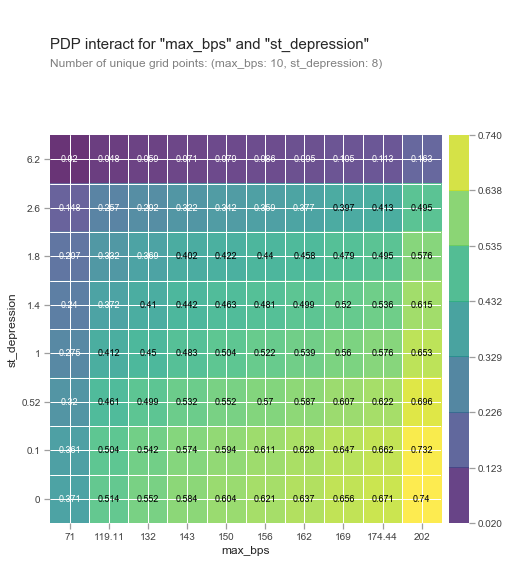

In [528]:

features_to_plot = ['max_bps', 'st_depression']
inter1  =  pdp.pdp_interact(model=model, dataset=df1, model_features=var_names,
                            features=features_to_plot,num_grid_points=[10, 10])

fig, axes = pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot,
                                  plot_type='grid')

## 9. Odds Ratios<a id = 'odds'></a>

Many medical publications are descriptive as opposed to predictive and often display variables in terms of odds ratios. Odds ratios tells us the likelihood of having heart disease for a given value in a variable as oppose to those that are not of the given value of that variable. Logistic regression is also based on the odds ratio as well. We'll look at one odds ratio below, then create some code to loop it through all the variables. 


In [286]:
#create a contingency table for sex_male and target
data_crosstab = pd.crosstab(df1['sex_male'], df1['target'], margins = True)
data_crosstab

target,0,1,All
sex_male,,,
0,24,72,96
1,114,93,207
All,138,165,303


So, the columns represent the presence of heart disease and the rows represent if the patient is male or female. For example, we have 93 patients that are male and have heart disease. The ALL rows and columns are summations. We have 303 in the bottom most right most number, same as the total number of rows we have in the dataset.

Let’s compute the odds ratio:

Patients that are male are x times more likely of having heart disease compared to those that are female.

In [533]:
#calculate odds ratio
odds_ratio = (93/114)/(72/24)
odds_ratio

0.2719298245614035

Now we can compute the 95% Confidence Interval for the odds ratio.

In [534]:
#step 1 calculate natural log of odds ratio
ln_odds_ratio = math.log(odds_ratio)

#step 2 calculate standard error of log 
a, b, c, d = 93, 114, 72, 24
se_log = math.sqrt((1/a)+(1/b)+(1/c)+(1/d))

#step 3 calculate the 95% CI on the natual log scale
lower_CI_log = ln_odds_ratio - (1.96*se_log)
upper_CI_log = ln_odds_ratio + (1.96*se_log)

#step 4 convert back to normal scale
math.exp(lower_CI_log), math.exp(upper_CI_log)

(0.1589340137115208, 0.4652611971419402)

Patients that are male are 0.27 times more likely of having heart disease compared to those that are female (about 1 to 4, male being less likely). We are 95% confident that the odds ratio lies between 0.16 to 0.47. 

Odds ratios only take binomial categorical variables. For the numerical and multi categorical values, we have to specify cut off point that separates the data. I generally chose it where there was the most distinction. For example, in a numerical variable, I chose it at the median.

In [290]:
#columns 
odds_ratio_storage = []
ci_lower_storage = []
ci_upper_storage = []

#set a copy of the dataframe
X2_adj = X_adj.copy()

#specify cut off points
X2_adj.loc[X2_adj['max_bps'] >= 150, 'max_bps_greater_150'] = 1
X2_adj.max_bps_greater_150 = X2_adj.max_bps_greater_150.fillna(0)

X2_adj.loc[X2_adj['cardiac_fluoro'] >= 1, 'cardiac_fluoro_greater_0'] = 1
X2_adj.cardiac_fluoro_greater_0 = X2_adj.cardiac_fluoro_greater_0.fillna(0)

X2_adj.loc[X2_adj['st_depression'] >= 1, 'st_depression_greater_1'] = 1
X2_adj.st_depression_greater_1 = X2_adj.st_depression_greater_1.fillna(0)

X2_adj = X2_adj.drop(columns = ['max_bps' ,'cardiac_fluoro', 'st_depression'])
X2_adj = X2_adj.astype(int)

#variable names
var_names_X2_adj = pd.Series(X2_adj.columns.values)

#put the dataframe back together
df1_adj = pd.concat([y, X2_adj],axis=1)

#loop through each variable
for i in var_names_X2_adj:
    data_crosstab = pd.crosstab(df1_adj[str(i)], df1_adj['target'], margins = True)

    odds_ratio = (data_crosstab.iloc[1 , 1]/data_crosstab.iloc[1 , 0])/(data_crosstab.iloc[0 , 1]/data_crosstab.iloc[0 , 0])

    #step 1 calculate natural log of odds ratio
    ln_odds_ratio = math.log(odds_ratio)

    #step 2 calculate standard error of log 
    a = data_crosstab.iloc[1 , 1]
    b = data_crosstab.iloc[1 , 0]
    c = data_crosstab.iloc[0 , 1]
    d = data_crosstab.iloc[0 , 0]
    se_log = math.sqrt((1/a)+(1/b)+(1/c)+(1/d))

    #step 3 calculate the 95% CI on the natual log scale
    lower_CI_log = ln_odds_ratio - (1.96*se_log)
    upper_CI_log = ln_odds_ratio + (1.96*se_log)

    #step 4 convert back to normal scale
    lower_ci = math.exp(lower_CI_log) 
    upper_ci = math.exp(upper_CI_log)
    
    #append the odds ratios and ci 
    odds_ratio_storage.append(odds_ratio)
    ci_lower_storage.append(lower_ci)
    ci_upper_storage.append(upper_ci)
    
#odds ratio table
odds_table = pd.DataFrame(data={'Variables': var_names_X2_adj, 'Odds Ratios' : odds_ratio_storage,
                                '95% CI Lower' : ci_lower_storage, '95% CI Upper' : ci_upper_storage})
odds_table.sort_values(by='Odds Ratios')

,Variables,Odds Ratios,95% CI Lower,95% CI Upper
6,thallium_rev_defect,0.112524,0.065866,0.192232
8,cardiac_fluoro_greater_0,0.130273,0.077781,0.218191
1,ex_angina,0.132135,0.075953,0.229873
9,st_depression_greater_1,0.187500,0.114570,0.306855
0,sex_male,0.271930,0.158934,0.465261
4,cp_non_anginal,2.009588,0.801902,5.036083
5,rest_ecg_st_abnormal,2.037267,1.286736,3.225571
2,cp_typical,4.739247,2.211003,10.158495
3,cp_atypical,4.791667,2.671973,8.592928
7,max_bps_greater_150,5.153299,3.149689,8.431463


For the odds ratios less than 1, if the variable is true than it would point towards less chance of heart disease. For the odds ratios greater than 1, if the variable is true that it would point towards the presence of heart disease.

## 10. Conclusion<a id = 'conclusion'></a>

Congrats for making it this far! We covered a fair amount and learned a lot along the way. Several of the most important factors were sex, max_bps, cardiac_fluoro, and the ECG related variables. For cardiac_fluoro and the ECG tests, we should expect these since they are tests for abnormalities of the heart. These variables were also noticeable in the EDA. From the logistic regression, since the performance was relatively good, we can say that there is a linear relationship between the variables to the presence of heart disease. However, we did not see cholesterol as an important factor in the presence of heart disease which is contradicting to what we typically hear from our doctors, at least for this dataset anyways. In short, I'm generally content with the analysis we did but there are more rabbit holes we can delve into such as black box models. I hope you found this insightful, thanks!

## 11. References<a id = 'ref'></a>

Heart Disease Image

https://www.webmd.com/heart-disease/ss/slideshow-heart-disease-affects-body

Correlation 

https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365
    
https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

Logistic Regression
https://en.wikipedia.org/wiki/Logistic_regression

Performance/ROC/etc.
https://en.wikipedia.org/wiki/Receiver_operating_characteristic

Odds Ratio
https://en.wikipedia.org/wiki/Odds_ratio